###### Курсовой проект для курса "Python для Data Science"

###### Материалы к проекту (файлы): train.csv test.csv

## Задание: 
> Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). 
> С помощью полученной модели предсказать цены для квартир из файла test.csv.

##### Целевая переменная: 
* Price

##### Основная метрика: 
* R2 - коэффициент детерминации (sklearn.metrics.r2_score)

##### Вспомогательная метрика: 
* MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

## Сдача проекта: 
>1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook  с расширением ipynb). 
>2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

##### Сроки сдачи: 
* Сдать проект за 72 часа до начала Урока 13 ("Вебинар. Результаты итоговых проектов и закрытие курса").

##### Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

#####  Подключаем библиотеки.

In [64]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['fivethirtyeight'])
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import gmtime

In [2]:
SOURCE_TRAIN_CSV = 'C:/Users/dmitriy.ivanov/Downloads/Kurs_project_task/train.csv'
SOURCE_TEST_CSV = 'C:/Users/dmitriy.ivanov/Downloads/Kurs_project_task/test.csv'
df_train = pd.read_csv(SOURCE_TRAIN_CSV)
df_test = pd.read_csv(SOURCE_TEST_CSV)
filename = 'DmitriyIvanov_pred.csv'

##### Функция межквартильного размаха.

In [3]:
def ir(name):
    a = df_train.loc[df_train[name] > 0,name].describe()
    eps = (a['75%'] - a['25%'])
    i_min = (a['25%'] - 1.5 * eps).astype(int)
    if i_min < 0:
        i_min = 0
    i_max = (a['75%'] + 1.5 * eps).astype(int) + 1
    df_i_range = pd.Series([i_min,i_max])
    return df_i_range

def irt(name):
    a = df_test.loc[df_test[name] > 0,name].describe()
    eps = (a['75%'] - a['25%'])
    i_min = (a['25%'] - 1.5 * eps).astype(int)
    if i_min < 0:
        i_min = 0
    i_max = (a['75%'] + 1.5 * eps).astype(int) + 1
    df_i_range = pd.Series([i_min,i_max])
    return df_i_range

##### Функция графика (повзаимствованная)

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

##### Удалим дубликаты, если таковые имеются.

In [6]:
df_train.drop_duplicates();

##### Установим поле id как индекс и переупорядочим его.

In [7]:
#df_train = df_train.set_index('Id')
#df_train.reset_index(inplace = True, drop = True)
#df_train.index.name = 'id'

##### Проверим наш датасет на null значения.

In [8]:
df_train.isnull().any();

##### Приведем некоторые типы к целым значениям

In [9]:
df_train['Rooms'] = df_train['Rooms'].astype(int)
df_train['HouseFloor'] = df_train['HouseFloor'].astype(int)

##### Поправим год строительства

In [10]:
x_min_year = ir('HouseYear')[0]
x_max_year = gmtime().tm_year

year_median = df_train.loc[df_train['HouseYear'].apply(lambda x: x <= x_max_year and x >= x_min_year),'HouseYear'].median()

df_train.loc[df_train['HouseYear'].apply(lambda x: x <= x_min_year or x >= x_max_year),'HouseYear'] = year_median

df_train['HouseYear'] = df_train['HouseYear'].astype(int)

df_train['HouseYear'].describe()

count    10000.000000
mean      1984.639100
std         17.743994
min       1934.000000
25%       1974.000000
50%       1977.000000
75%       1999.250000
max       2018.000000
Name: HouseYear, dtype: float64

##### Поправим этажность домов

In [11]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].median()

In [12]:
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'HouseFloor'] = df_train['HouseFloor'].median()

##### Поправим этаж квартир

In [13]:
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], {'Floor'}] = df_train['HouseFloor'].apply(lambda x: random.randint(1, x))

##### Проверим, что нет больше квартир находящихся за пределом этажности дома

In [14]:
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], {'Floor'}];

##### Поправим выбросы по комнатам 

In [15]:
df_train['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
6        1
19       1
Name: Rooms, dtype: int64

##### Для начала вычислим медианное значение кол-ва комнат по району и году постройки

In [16]:
filter1 = df_train.loc[~df_train['Rooms'].isin([19,10,0,6]),{'DistrictId','HouseYear','Rooms'}]
filter1 = filter1.groupby(['DistrictId','HouseYear']).median()
a = df_train.loc[df_train['Rooms'].isin([19,10,0,6]),{'DistrictId','HouseYear','Rooms'}]
b = pd.merge(a, filter1, on=['DistrictId','HouseYear'],how='left')

##### Вычислили медианное значение для комнат такого типа

In [17]:
b['Rooms_y'].median()

2.0

##### Проверим, что нет null значений

In [18]:
df_train['Rooms'].isnull().any()

False

##### Изменим неправильные начения на медианные

In [19]:
df_train.loc[df_train['Rooms'].isin([19,10,0])] = b['Rooms_y'].median()

##### Разберемся с площадью кухни

In [20]:
x_min_ksquare = ir('KitchenSquare')[0]
x_max_ksquare = ir('KitchenSquare')[1]
x_med_ksquare = df_train['KitchenSquare'].median()

##### Поправим большие значения выходящие за максимальный размах более чем в 2 раза. В нашем случаее размах = 22

In [21]:
df_train.loc[df_train['KitchenSquare'] > x_max_ksquare*2, 'KitchenSquare'] = x_max_ksquare*random.randint(1, 3)

##### Посмотрим на площадь кухонь менее 5 метров. Логично пердположить, что таких должно быть немного, но картина другая

In [22]:
df_train.loc[df_train['KitchenSquare'] < 5, 'KitchenSquare'].value_counts()

1.0    2460
0.0     690
4.0      39
3.0      22
2.0      15
Name: KitchenSquare, dtype: int64

##### Поправим все кухни менее 5 метров на медианное значение

In [23]:
df_train.loc[df_train['KitchenSquare'] < 5, 'KitchenSquare'] = x_med_ksquare

In [24]:
df_train['KitchenSquare'].describe()

count    10000.000000
mean         7.441400
std          2.605196
min          5.000000
25%          6.000000
50%          6.000000
75%          9.000000
max         43.000000
Name: KitchenSquare, dtype: float64

##### Healthcare_1 Заполним пустые значения медианными и заполним значения которые выходят за размах

In [25]:
x_min_h1 = ir('Healthcare_1')[0]
x_max_h1 = ir('Healthcare_1')[1]

h1_median = df_train.loc[df_train['Healthcare_1'].apply(lambda x: x <= x_max_h1 and x >= x_min_h1),'Healthcare_1'].median()

df_train.loc[df_train['Healthcare_1'].isnull() == True, 'Healthcare_1'] = df_train['Healthcare_1'].median()

df_train.loc[df_train['Healthcare_1'].apply(lambda x: x <= x_min_h1 or x >= x_max_h1),'Healthcare_1'] = h1_median

df_train['Healthcare_1'].median()

900.0

##### Healthcare_2 распределение выглядит  нормальным, менять не будем

In [26]:
df_train['Helthcare_2'].sort_values().value_counts()

0.0    4207
1.0    2182
3.0    1669
2.0    1168
5.0     387
4.0     288
6.0      99
Name: Helthcare_2, dtype: int64

##### Заполним пустые значения жилой площади

In [27]:
df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] =\
df_train[~df_train['LifeSquare'].isnull()]['LifeSquare'].median()

##### Пересчитаем значения для некорректной жилой площади

In [28]:
df_train.loc[(df_train['LifeSquare'] > df_train['Square'] + df_train['KitchenSquare']),'LifeSquare'] =\
df_train['Square'] - df_train['KitchenSquare']

##### Исправим выбросы для общей площади

In [29]:
s25 = df_train['Square'].quantile(.25) 
s75 = df_train['Square'].quantile(.75)
sdiff = s75 - s25
smax = s75 + 1.5*sdiff
smin = s25 - 1.5*sdiff

df_train.loc[df_train['Square']> smax*1.5, 'Square'] = df_train[df_train['Square']> smax*1.5].median()['Square']

##### Удалим явно неправильные данные

In [30]:
p25 = df_train['Price'].quantile(.25) 
p75 = df_train['Price'].quantile(.75)
pdiff = p75 - p25
pmax = p75 + 1.5*pdiff
pmin = p25 - 1.5*pdiff

df_train = df_train.drop(df_train[(df_train['Square'] < smin) & (df_train['Price'] < pmin)].index)
df_train[(df_train['Square'] < smin)] = df_train['Square'].median()

##### Экология

In [31]:
df_train['E_2'] = df_train['Ecology_2'].replace({'A':2, 'B':1})
df_train['E_3'] = df_train['Ecology_3'].replace({'A':2, 'B':1})

##### Магазины

In [32]:
df_train['S_2'] = df_train['Shops_2'].replace({'A':2, 'B':1})

##### Была идея расчитать медианную цену за 1 метр квадратный по району, но медианная цена с учетом площади, этажа и кол-ва комнат показала себя лучше

In [33]:
#med_price_by_district = df_train.groupby(['DistrictId', 'Square', 'Floor', 'Rooms'], as_index=False).agg({'Price':'median'})\
#                        .rename(columns={'Price':'MedPriceByDistrict'})
med_price_by_district = df_train.groupby(['DistrictId', 'Rooms' ,'Floor', 'HouseYear'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'MedPriceByDistrict'})

##### Введем еще один категориальный признак размер района, но возможно от него стоит отказаться, т.к. этот признак влияет не существенно.

In [34]:
district_size = df_train['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
df_train = df_train.merge(district_size, on='DistrictId', how='left')

df_train['IsDistrictLarge'] = (df_train['DistrictSize'] > df_train['DistrictSize'].median()).astype(int)

##### Добавим наши новые признаки в датасет

In [35]:
df_train = df_train.merge(med_price_by_district, on=['DistrictId', 'Rooms', 'Floor', 'HouseYear'], how='left')

##### Запишем список фичей в переменные

In [36]:
feature_names = ['Id','Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'E_2', 'E_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'S_2']

new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

##### Определим датафреймы для нашей модели

In [37]:
X = df_train[feature_names + new_feature_names]
y = df_train[target_name]

##### Проверим isnull значение еще раз

In [38]:
df_train.isnull().any();

##### Посмотрим описание нашего датасета

In [39]:
df_train.describe();

##### Обнаружены еще выбросы которые мы не поправили 

In [40]:
df_train.loc[(df_train['LifeSquare'] < 9),'LifeSquare'] = (df_train['Square'].median() - df_train['KitchenSquare'].median())

##### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ___ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

##### Обучим нашу модель и посмотрим результаты. Подобрав гипер-параметр глубины дерева остановился на 11, т.к. данное значение показывает наилучший score на кросс-валидационной проверке

Train R2:	0.992
Test R2:	0.972


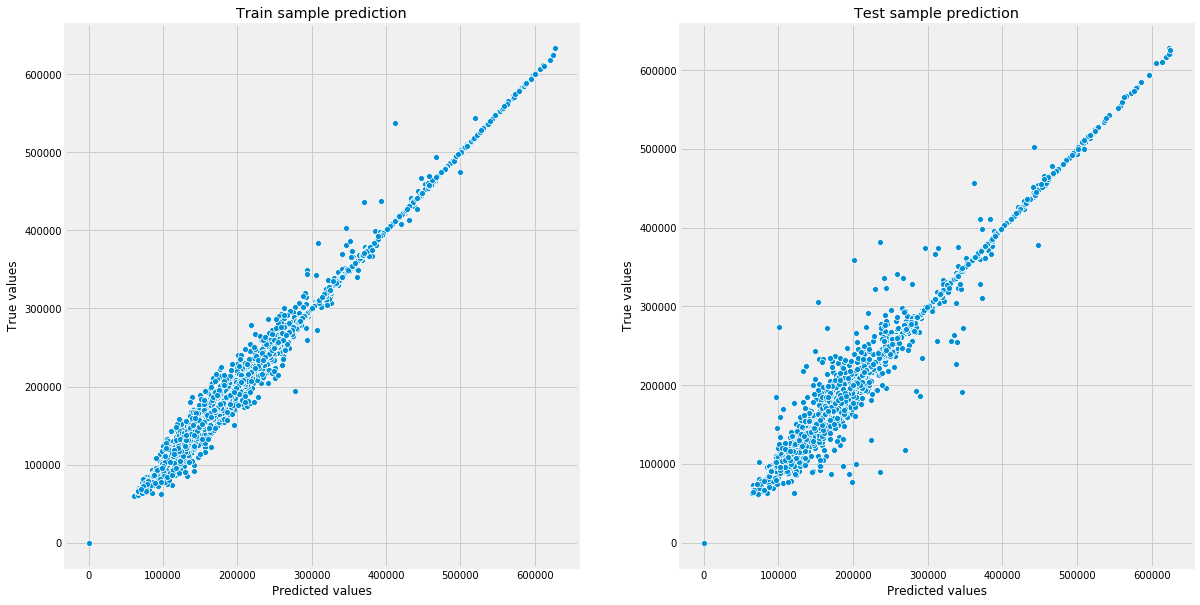

In [41]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

rf_model = RandomForestRegressor(random_state=21, oob_score = True, max_depth = 11, n_estimators = 37)
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

##### Кросс валидация, считаю, что 6 разбиений показвает лучше качество нашей модели чем 3 по умолчание

In [42]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=6, shuffle=True, random_state=21))
cv_score.mean()

0.97346852541849

* 0.9999959605613693 - лучший результат, но мое мнение это уже предел погрешности

##### Важность фичей, как и следовало предположить наша гипер-фича имеет топ 1

In [43]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by = 'importance', ascending = False)

,feature_name,importance
19,MedPriceByDistrict,0.982964
2,Square,0.005531
3,LifeSquare,0.001708
0,Id,0.001263
6,HouseFloor,0.001093
12,Social_2,0.001068
11,Social_1,0.001058
5,Floor,0.001037
8,Ecology_1,0.000942
16,Shops_1,0.000591


In [44]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,E_2,E_3,S_2,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038.0,35.0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,...,0.0,11.0,B,184966.930730,1.0,1.0,1.0,22,0,189571.162921
1,15053.0,41.0,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,...,1.0,16.0,B,300009.450063,1.0,1.0,1.0,87,0,300009.450063
2,4765.0,53.0,2.0,44.947953,29.197612,6.0,8.0,12.0,1968.0,0.049637,...,1.0,3.0,B,220925.908524,1.0,1.0,1.0,174,1,220925.908524
3,5809.0,58.0,2.0,53.352981,52.731512,9.0,8.0,17.0,1977.0,0.437885,...,0.0,5.0,B,175616.227217,1.0,1.0,1.0,179,1,176106.762660
4,10783.0,99.0,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,...,2.0,4.0,B,150226.531644,1.0,1.0,1.0,97,0,150226.531644


### Прогнозирование на тестовом датасете

> 1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
> 2. Не потерять и не перемешать индексы от примеров при построении прогнозов
> 3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [45]:
df_test.head().sort_values(by = 'Id', ascending = True)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B


##### Применим все наши трансформации для тестового датасета

In [46]:
df_test['Rooms'] = df_test['Rooms'].astype(int)

df_test['HouseFloor'] = df_test['HouseFloor'].astype(int)

x_min_yeart = irt('HouseYear')[0]

x_max_yeart = gmtime().tm_year

year_mediant = df_test.loc[df_test['HouseYear'].apply(lambda x: x <= x_max_yeart and x >= x_min_yeart),'HouseYear'].median()

df_test.loc[df_test['HouseYear'].apply(lambda x: x <= x_min_yeart or x >= x_max_yeart),'HouseYear'] = year_mediant

df_test['HouseYear'] = df_test['HouseYear'].astype(int)

df_test.loc[df_test['HouseFloor'] == 0, 'HouseFloor'] = df_test['HouseFloor'].median()

df_test.loc[df_test['Floor'] > df_test['HouseFloor'], 'HouseFloor'] = df_test['HouseFloor'].median()

df_test.loc[df_test['Floor'] > df_test['HouseFloor'], {'Floor'}] = df_test['HouseFloor'].apply(lambda x: random.randint(1, x))

filter1t = df_test.loc[~df_test['Rooms'].isin([19,10,0,6]),{'DistrictId','HouseYear','Rooms'}]

filter1t = filter1t.groupby(['DistrictId','HouseYear']).median()

a = df_test.loc[df_test['Rooms'].isin([19,10,0,6]),{'DistrictId','HouseYear','Rooms'}]

b = pd.merge(a, filter1t, on=['DistrictId','HouseYear'],how='left')

df_test.loc[df_test['Rooms'].isin([19,10,0])] = b['Rooms_y'].median()

x_min_ksquaret = irt('KitchenSquare')[0]

x_max_ksquaret = irt('KitchenSquare')[1]

x_med_ksquaret = df_test['KitchenSquare'].median()

df_test.loc[df_test['KitchenSquare'] > x_max_ksquaret*2, 'KitchenSquare'] = x_max_ksquaret*random.randint(1, 3)

df_test.loc[df_test['KitchenSquare'] < 5, 'KitchenSquare'] = x_med_ksquaret

x_min_h1t = irt('Healthcare_1')[0]

x_max_h1t = irt('Healthcare_1')[1]

h1_mediant = df_test.loc[df_test['Healthcare_1'].apply(lambda x: x <= x_max_h1t and x >= x_min_h1t),'Healthcare_1'].median()

df_test.loc[df_test['Healthcare_1'].isnull() == True, 'Healthcare_1'] = df_test['Healthcare_1'].median()

df_test.loc[df_test['Healthcare_1'].apply(lambda x: x <= x_min_h1t or x >= x_max_h1t),'Healthcare_1'] = h1_mediant

df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] =\
df_test[~df_test['LifeSquare'].isnull()]['LifeSquare'].median()

df_test.loc[(df_test['LifeSquare'] > df_test['Square'] + df_test['KitchenSquare']),'LifeSquare'] =\
df_test['Square'] - df_test['KitchenSquare']

s25t = df_test['Square'].quantile(.25) 

s75t = df_test['Square'].quantile(.75)

sdifft = s75t - s25t

smaxt = s75t + 1.5*sdifft

smint = s25t - 1.5*sdifft

df_test.loc[df_test['Square']> smaxt*1.5, 'Square'] = df_test[df_test['Square']> smaxt*1.5].median()['Square']

df_test['E_2'] = df_test['Ecology_2'].replace({'A':2, 'B':1})

df_test['E_3'] = df_test['Ecology_3'].replace({'A':2, 'B':1})

df_test['S_2'] = df_test['Shops_2'].replace({'A':2, 'B':1})

##### У нас образовались некотрые пробелы в заполнении признака MedPriceByDistrict заполним их

In [47]:
m = med_price_by_district.groupby(['DistrictId','Rooms']).median()

df_test = df_test.merge(m, on = ['DistrictId','Rooms'], how='left')

df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor_x,HouseFloor,HouseYear_x,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,E_2,E_3,S_2,Floor_y,HouseYear_y,MedPriceByDistrict
0,725.0,58.0,2.0,49.882643,33.432782,6.0,6.0,14.0,1972.0,0.310199,...,900.0,0.0,0.0,B,1.0,1.0,1.0,7.0,1977.0,170405.926959
1,15856.0,74.0,2.0,69.263183,32.917704,6.0,6.0,12.0,1977.0,0.075779,...,900.0,0.0,2.0,B,1.0,1.0,1.0,8.0,1992.0,241426.396100
2,5480.0,190.0,1.0,13.597819,15.948246,12.0,2.0,5.0,1977.0,0.000000,...,810.0,5.0,5.0,B,1.0,1.0,1.0,NaN,NaN,NaN
3,15664.0,47.0,2.0,73.046609,51.940842,9.0,22.0,22.0,2007.0,0.101872,...,900.0,3.0,3.0,B,1.0,1.0,1.0,7.0,1979.0,222907.751380
4,14275.0,27.0,1.0,47.527111,43.387569,6.0,17.0,17.0,2017.0,0.072158,...,900.0,0.0,0.0,A,1.0,1.0,2.0,9.0,2013.0,119638.235517


In [48]:
test_gap = df_test[(df_test['MedPriceByDistrict'].isnull())]

In [49]:
med_train = df_train.groupby(['DistrictId']).median()['MedPriceByDistrict']/df_train.groupby(['DistrictId']).median()['Square']
med_train = pd.DataFrame(med_train,columns=['pp1m'])

In [50]:
test_gap.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor_x,HouseFloor,HouseYear_x,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,E_2,E_3,S_2,Floor_y,HouseYear_y,MedPriceByDistrict
2,5480.0,190.0,1.0,13.597819,15.948246,12.0,2.0,5.0,1977.0,0.000000,...,810.0,5.0,5.0,B,1.0,1.0,1.0,NaN,NaN,NaN
51,15748.0,212.0,2.0,75.655182,36.877626,15.0,2.0,7.0,1977.0,0.000000,...,562.0,1.0,8.0,B,1.0,1.0,1.0,NaN,NaN,NaN
149,3764.0,193.0,4.0,97.931642,72.386905,8.0,5.0,5.0,1957.0,0.319809,...,2857.0,5.0,8.0,B,1.0,1.0,1.0,NaN,NaN,NaN
255,10816.0,51.0,3.0,97.889332,58.640564,12.0,4.0,5.0,1977.0,0.015017,...,2890.0,0.0,8.0,B,1.0,1.0,1.0,NaN,NaN,NaN
263,11407.0,79.0,4.0,37.920348,21.357487,6.0,6.0,17.0,2014.0,0.307467,...,325.0,2.0,5.0,B,1.0,2.0,1.0,NaN,NaN,NaN


In [51]:
test_gap = test_gap.merge(med_train, on = ['DistrictId'], how='left')
test_gap2 = test_gap[(test_gap['MedPriceByDistrict'].isnull())]

In [52]:
test_gap.loc[test_gap['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = test_gap2['Square'] * med_train['pp1m'].median()

In [53]:
df_test.loc[df_test['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = df_test['MedPriceByDistrict'].median()

In [54]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor_x,HouseFloor,HouseYear_x,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,E_2,E_3,S_2,Floor_y,HouseYear_y,MedPriceByDistrict
0,725.0,58.0,2.0,49.882643,33.432782,6.0,6.0,14.0,1972.0,0.310199,...,900.0,0.0,0.0,B,1.0,1.0,1.0,7.0,1977.0,170405.926959
1,15856.0,74.0,2.0,69.263183,32.917704,6.0,6.0,12.0,1977.0,0.075779,...,900.0,0.0,2.0,B,1.0,1.0,1.0,8.0,1992.0,241426.396100
2,5480.0,190.0,1.0,13.597819,15.948246,12.0,2.0,5.0,1977.0,0.000000,...,810.0,5.0,5.0,B,1.0,1.0,1.0,NaN,NaN,197105.523484
3,15664.0,47.0,2.0,73.046609,51.940842,9.0,22.0,22.0,2007.0,0.101872,...,900.0,3.0,3.0,B,1.0,1.0,1.0,7.0,1979.0,222907.751380
4,14275.0,27.0,1.0,47.527111,43.387569,6.0,17.0,17.0,2017.0,0.072158,...,900.0,0.0,0.0,A,1.0,1.0,2.0,9.0,2013.0,119638.235517


##### Удалим ненужные колонки

In [55]:
#df_train = df_train.drop(df_train[(df_train['Square'] < smin) & (df_train['Price'] < pmin)].index)
df_test = df_test.drop('Shops_2', axis=1)
df_test = df_test.drop('Ecology_2', axis=1)
df_test = df_test.drop('Ecology_3', axis=1)
df_test = df_test.drop('Floor_y', axis=1)
df_test = df_test.drop('HouseYear_y', axis=1)

##### Проверим что нет null значений

In [56]:
df_test.isnull().any()

Id                    False
DistrictId            False
Rooms                 False
Square                False
LifeSquare            False
KitchenSquare         False
Floor_x               False
HouseFloor            False
HouseYear_x           False
Ecology_1             False
Social_1              False
Social_2              False
Social_3              False
Healthcare_1          False
Helthcare_2           False
Shops_1               False
E_2                   False
E_3                   False
S_2                   False
MedPriceByDistrict    False
dtype: bool

##### Сделаем предсказания цен

In [57]:
a = rf_model.predict(df_test)

In [58]:
a = pd.DataFrame(a,columns=['Price'])
a.head()

,Price
0,178159.579803
1,218695.853096
2,190384.752900
3,220371.829907
4,115037.284232


##### Проверим длинну нашего датафрейма

In [59]:
len(a)

5000

##### объединим нужные колонки и выгрузим в файл

In [66]:
result = pd.concat([df_test['Id'].astype(int) , a['Price']], axis=1, sort=False)

result.to_csv(filename,index=False,encoding='utf-8')

PermissionError: [Errno 13] Permission denied: 'DmitriyIvanov_pred.csv'